In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import openml
import pandas as pd

In [2]:
def log_filter(df_before, df_after, description):
    removed = len(df_before) - len(df_after)
    print(f"{description: <30} | Removed: {removed: >5} | Remaining: {len(df_after): >6}")
    return df_after


# Fetch datasets
all_datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(f"Initial datasets: {len(all_datasets_df)}\n" + "-" * 60)

# 1. Remove invalid NumberOfClasses (0, 1, or NaN)
df = log_filter(
    all_datasets_df,
    all_datasets_df[
        all_datasets_df["NumberOfClasses"].notna()
        & ~all_datasets_df["NumberOfClasses"].isin([0, 1])
    ],
    "Invalid NumberOfClasses",
)

# 2. Keep only the latest version per dataset name (tie-breaker: largest did)
df = log_filter(
    df,
    df.sort_values(["name", "version", "did"]).drop_duplicates(subset="name", keep="last"),
    "Exact name duplicates",
)

# 3. Deduplicate by normalized name (replace digits with <NUM>)
# Prefer larger NumberOfInstances, then larger version, then larger did
df["norm_digits"] = df["name"].astype(str).str.replace(r"\d+", "<NUM>", regex=True)
df = log_filter(
    df,
    df.assign(inst_fill=df["NumberOfInstances"].fillna(-1))
    .sort_values(["inst_fill", "version", "did"], ascending=False)
    .drop_duplicates(subset="norm_digits", keep="first")
    .drop(columns=["inst_fill"]),
    "Normalized name duplicates",
)

# 4. Remove specific uploader (32840) and FOREX-prefixed names
is_blacklisted_uploader = df["uploader"] == "32840"
is_forex = df["name"].str.strip().str.upper().str.startswith("FOREX_")
df = log_filter(df, df[~(is_blacklisted_uploader | is_forex)], "Uploader/FOREX exclusions")

# 5. Apply range filters for classes, instances, and features
mask_ranges = (
    df["NumberOfClasses"].between(2, 15)
    & df["NumberOfInstances"].between(100, 2500)
    & df["NumberOfFeatures"].between(1, 200)
)
all_datasets_df = log_filter(df, df[mask_ranges].reset_index(drop=True), "Range constraints")

Initial datasets: 6384
------------------------------------------------------------
Invalid NumberOfClasses        | Removed:  3682 | Remaining:   2702
Exact name duplicates          | Removed:   548 | Remaining:   2154
Normalized name duplicates     | Removed:   665 | Remaining:   1489
Uploader/FOREX exclusions      | Removed:   276 | Remaining:   1213
Range constraints              | Removed:   853 | Remaining:    360


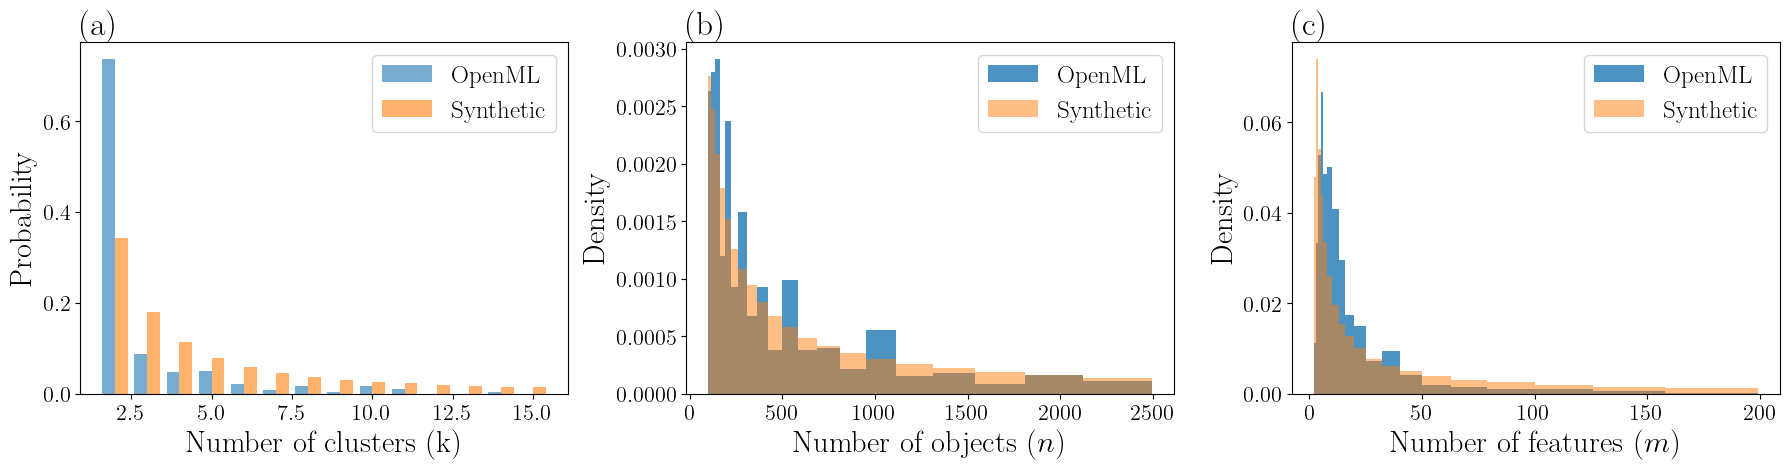

In [5]:
# --- Configuration & Paths ---
GEN_PATH = Path("results/generated_configs.csv")
FIG_PATH = Path("results/figures/openml_vs_generated.pdf")
ALPHA_DEFAULT = 1.6
N_BINS = 20

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.titlesize": 24,
        "axes.labelsize": 22,
        "legend.fontsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    }
)


def load_and_validate_gen_data(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Could not find {path.resolve()}")
    df = pd.read_csv(path)
    required = {"num_clusters", "num_samples", "num_dimensions"}
    if not required.issubset(df.columns):
        missing = sorted(required - set(df.columns))
        raise KeyError(f"CSV missing columns: {missing}")
    return df


def get_log_edges(lo: float, hi: float, n: int) -> np.ndarray:
    edges = np.logspace(np.log10(max(1, lo)), np.log10(hi), n + 1)
    return np.unique(np.round(edges).astype(int))


# --- Main Logic ---

# 1. Data Prep
FIG_PATH.parent.mkdir(parents=True, exist_ok=True)
df_gen = load_and_validate_gen_data(GEN_PATH)
k_gen, n_gen, d_gen = [
    df_gen[c].astype(int).to_numpy() for c in ["num_clusters", "num_samples", "num_dimensions"]
]

if not all(name in globals() for name in ["k", "n", "d"]):
    k_openml = all_datasets_df["NumberOfClasses"].dropna().astype(int).to_numpy()
    n_openml = all_datasets_df["NumberOfInstances"].dropna().to_numpy()
    d_openml = all_datasets_df["NumberOfFeatures"].dropna().astype(int).to_numpy()

# 2. Bounds & Binning
bounds = {
    "k": (int(k_gen.min()), int(k_gen.max())),
    "n": (int(n_gen.min()), int(n_gen.max())),
    "d": (int(d_gen.min()), int(d_gen.max())),
}

k_values = np.arange(bounds["k"][0], bounds["k"][1] + 1)
k_openml_counts = np.bincount(
    np.clip(k_openml, *bounds["k"]) - bounds["k"][0], minlength=len(k_values)
)
k_gen_counts = np.bincount(k_gen - bounds["k"][0], minlength=len(k_values))

n_edges = get_log_edges(*bounds["n"], N_BINS)
d_edges = get_log_edges(*bounds["d"], N_BINS)

# 3. Visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# K Distribution
axs[0].bar(
    k_values - 0.2, k_openml_counts / k_openml_counts.sum(), width=0.4, label="OpenML", alpha=0.6
)
axs[0].bar(
    k_values + 0.2, k_gen_counts / k_gen_counts.sum(), width=0.4, label="Synthetic", alpha=0.6
)
axs[0].set_title(r"(a)", loc="left")
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("Probability")
axs[0].legend()
axs[0].grid(False)

# N & D Distributions
for ax, data_oml, data_gen, edges, title, xlabel in [
    (axs[1], n_openml, n_gen, n_edges, r"(b)", "Number of objects ($n$)"),
    (axs[2], d_openml, d_gen, d_edges, r"(c)", "Number of features ($m$)"),
]:
    ax.hist(data_oml, bins=edges, density=True, alpha=0.8, label="OpenML")
    ax.hist(data_gen, bins=edges, density=True, alpha=0.5, label="Synthetic")
    ax.set_title(title, loc="left")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(False)

plt.tight_layout(rect=(0, 0, 1, 0.96))
fig.savefig(FIG_PATH, dpi=600, format="pdf", bbox_inches="tight")
plt.show()